In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
file_path = "merged_CIC_IDS2017.csv"
df = pd.read_csv(file_path)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [3]:
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])


Missing values per column:
Flow Bytes/s    1358
dtype: int64


In [4]:
# Drop rows with missing values
df.dropna(inplace=True)

# Replace Infinite Values
df.replace([np.inf, -np.inf], 0, inplace=True)

#Drop Duplicated Columns
df = df.loc[:, ~df.columns.duplicated()]

print(f"Dataset after cleaning: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset after cleaning: 2829385 rows, 79 columns


In [5]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [6]:
df.shape

(2829385, 79)

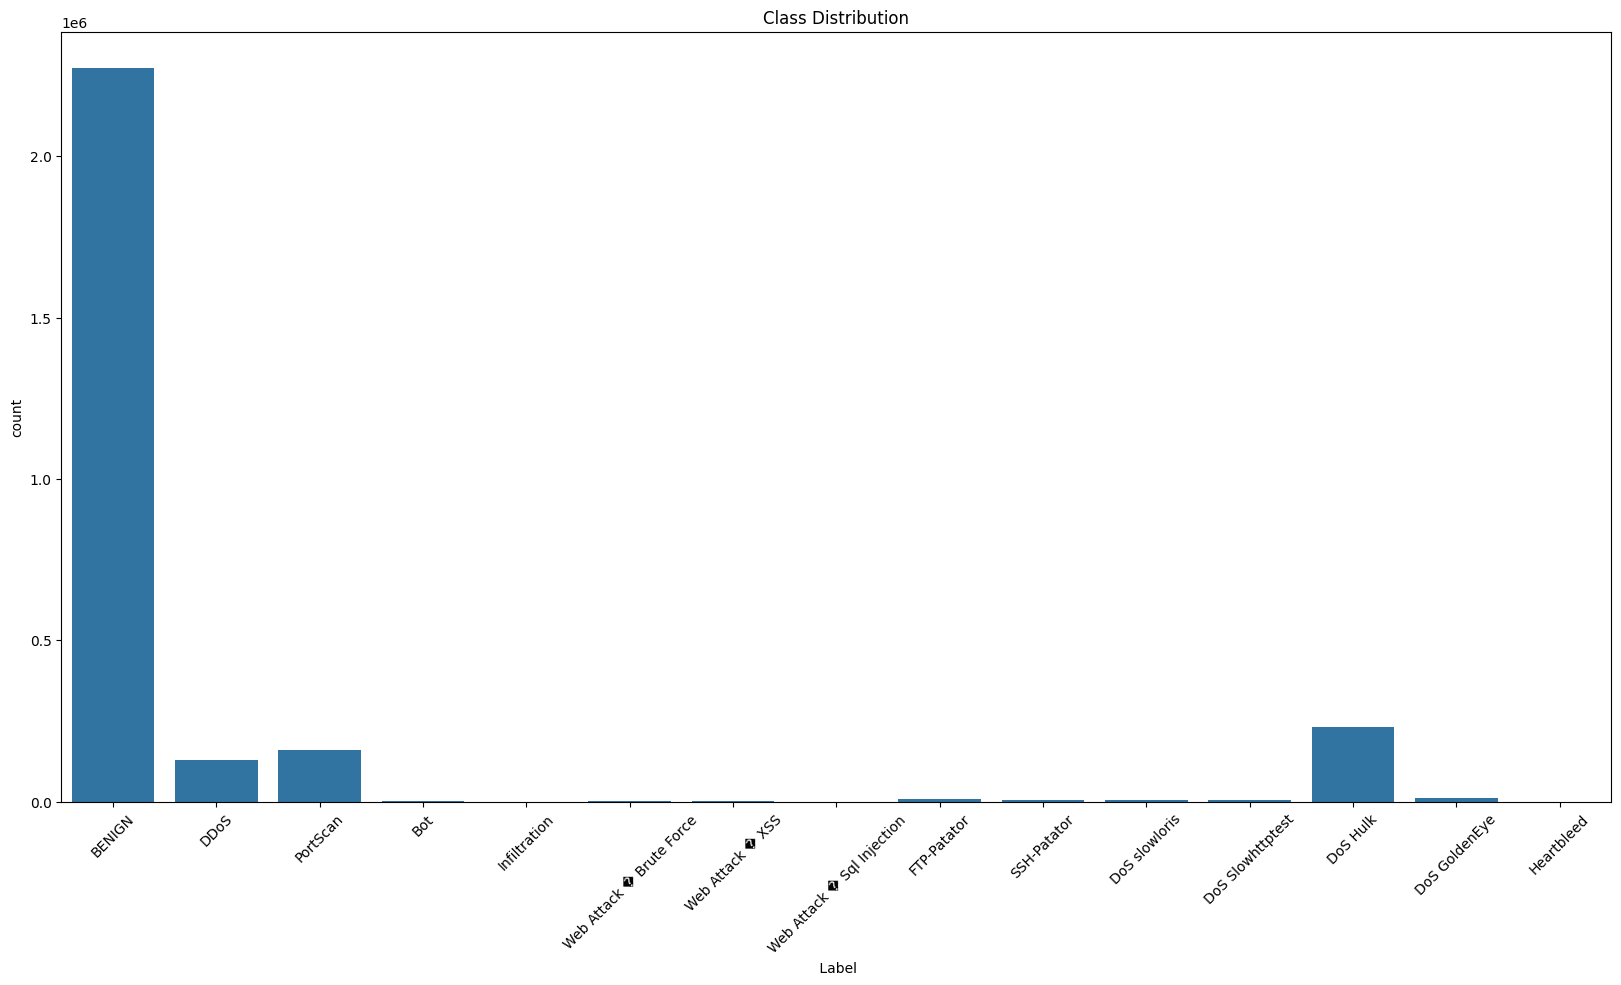

In [7]:
plt.figure(figsize=(20, 10))
sns.countplot(x=' Label', data=df)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [8]:
print(df[' Label'].value_counts())

 Label
BENIGN                        2272688
DoS Hulk                       230124
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [9]:
# Convert labels to binary (0 = Normal, 1 = Attack)
df[' Label'] = df[' Label'].apply(lambda x: 0 if x == "BENIGN" else 1)

# Check updated distribution
print(df[' Label'].value_counts())


 Label
0    2272688
1     556697
Name: count, dtype: int64


CORRELATION HEATMAP

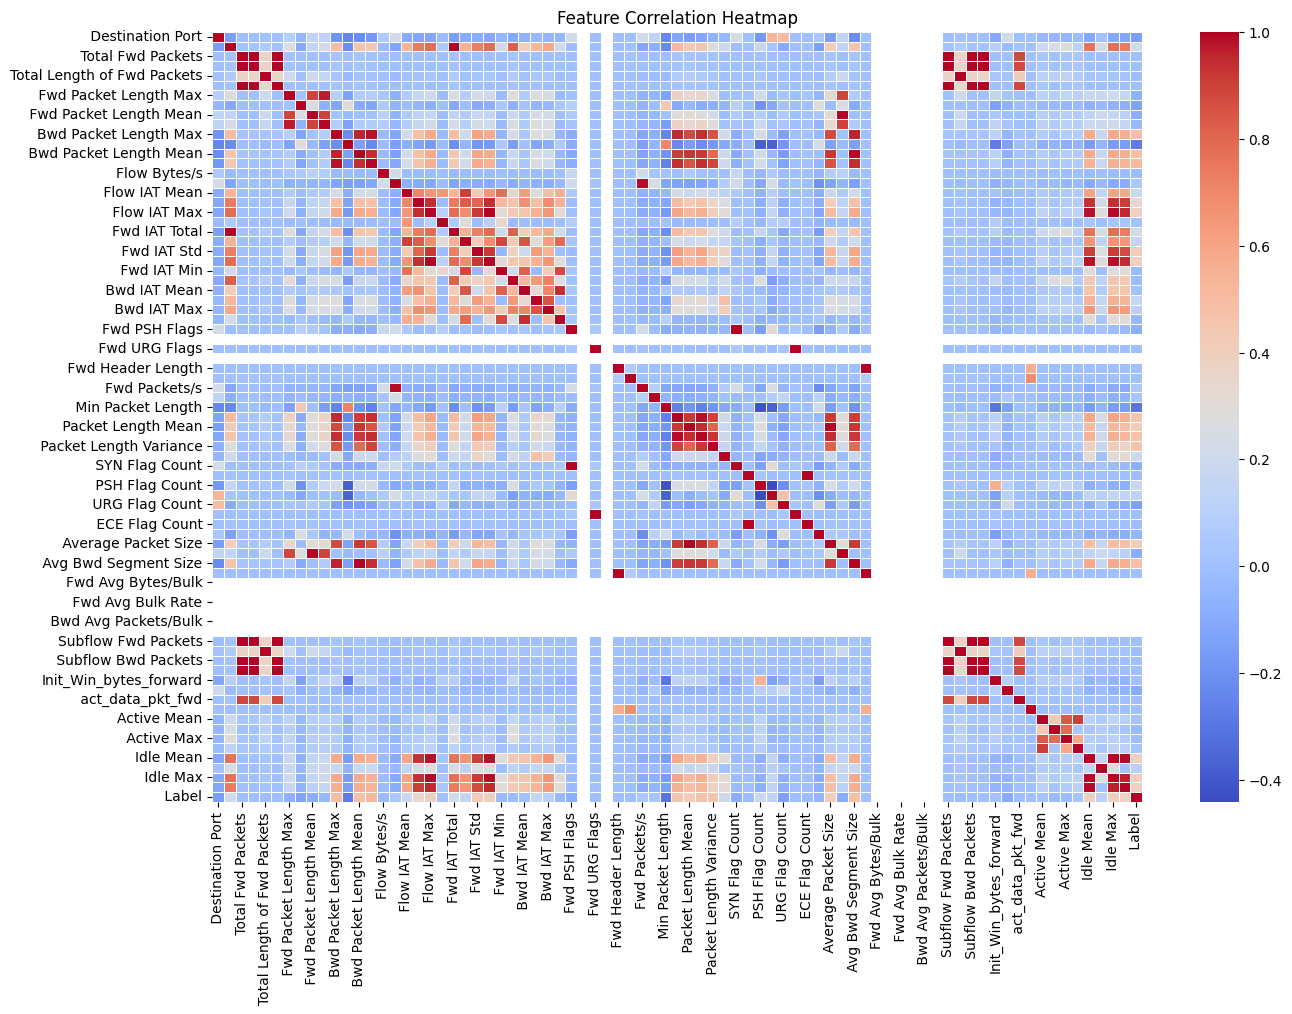

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Remove non-numeric columns (e.g., 'Label' if it's categorical)
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [11]:
import numpy as np

# Compute Pearson correlation matrix
correlation_matrix = df.corr(method='pearson')

# Extract upper triangle of the correlation matrix (excluding diagonal)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find pairs with high correlation (absolute value > 0.9)
high_correlation_pairs = upper_triangle.stack().reset_index()
high_correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[abs(high_correlation_pairs['Correlation']) > 0.9]

# Display results
print(high_correlation_pairs)


                 Feature 1                     Feature 2  Correlation
88           Flow Duration                 Fwd IAT Total     0.998560
139      Total Fwd Packets        Total Backward Packets     0.999070
141      Total Fwd Packets   Total Length of Bwd Packets     0.996993
190      Total Fwd Packets           Subflow Fwd Packets     1.000000
192      Total Fwd Packets           Subflow Bwd Packets     0.999070
...                    ...                           ...          ...
2380   Subflow Bwd Packets             Subflow Bwd Bytes     0.994424
2451           Active Mean                    Active Min     0.905862
2476             Idle Mean                      Idle Max     0.990386
2477             Idle Mean                      Idle Min     0.990215
2482              Idle Max                      Idle Min     0.961809

[71 rows x 3 columns]


In [12]:
import numpy as np

# Compute Pearson correlation matrix
correlation_matrix = df.corr(method='pearson')

# Find upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find columns with correlation above 0.9
to_drop = [column for column in upper_triangle.columns if any(abs(upper_triangle[column]) > 0.9)]

# Drop the columns
df.drop(columns=to_drop, inplace=True)

print(f"Dropped {len(to_drop)} highly correlated features.")
print("Remaining features:", df.shape[1])


Dropped 31 highly correlated features.
Remaining features: 48


In [13]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       'Bwd Packet Length Max', ' Bwd Packet Length Min', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Min',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags',
       ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length',
       ' Bwd Packets/s', ' Min Packet Length', 'FIN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' Down/Up Ratio', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
       ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' act_data_pkt_fwd',
       ' min_seg_size_forward',

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Splitting data
X = df.drop(columns=[' Label'])
y = df[' Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model to check feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 20 Most Important Features:\n", feature_importances.head(20))

# OPTIONAL: Drop highly correlated features that have low importance (set threshold based on results)
low_importance_features = feature_importances[feature_importances < 0.01].index.tolist()
df.drop(columns=low_importance_features, inplace=True)

print(f"Dropped {len(low_importance_features)} low-importance features after feature selection.")
print("Remaining features:", df.shape[1])



Top 20 Most Important Features:
 Bwd Packet Length Max          0.106497
 Destination Port              0.092202
Total Length of Fwd Packets    0.061778
Init_Win_bytes_forward         0.051563
 Flow IAT Mean                 0.046401
 Fwd Packet Length Mean        0.040934
 Flow IAT Std                  0.039269
 Init_Win_bytes_backward       0.038918
 Fwd Header Length             0.037684
 Flow Packets/s                0.036825
 Fwd Packet Length Max         0.036561
 Min Packet Length             0.034702
 Total Fwd Packets             0.032511
 Bwd Header Length             0.032331
 Bwd Packets/s                 0.032044
 min_seg_size_forward          0.029201
 Bwd Packet Length Min         0.029101
Flow Bytes/s                   0.024964
 PSH Flag Count                0.024616
 Flow Duration                 0.020343
dtype: float64
Dropped 20 low-importance features after feature selection.
Remaining features: 28


In [15]:
from sklearn.feature_selection import VarianceThreshold

# Exclude the label column
X = df.drop(columns=[' Label'], errors='ignore')  

# Initialize variance threshold selector
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold if needed

# Fit the selector to the dataset
selector.fit(X)

# Get feature names with low variance
low_variance_features = X.columns[~selector.get_support()]

print(f"Features with near-zero variance:\n{low_variance_features}")


Features with near-zero variance:
Index([], dtype='object')


In [16]:
df= df.drop(columns=low_variance_features, errors='ignore')

print(f"Shape after dropping near-zero variance features: {df.shape}")


Shape after dropping near-zero variance features: (2829385, 28)


In [17]:
df_cleaned = df.loc[:, ~df.columns.duplicated()]
print(f"Shape after removing duplicate columns: {df_cleaned.shape}")


Shape after removing duplicate columns: (2829385, 28)


In [18]:
# Check if any missing values exist
print("Missing values per column:\n", df_cleaned.isnull().sum())

# Replace infinite values with large finite numbers
df_cleaned.replace([float('inf'), -float('inf')], 0, inplace=True)


Missing values per column:
  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
Total Length of Fwd Packets    0
 Fwd Packet Length Max         0
 Fwd Packet Length Min         0
 Fwd Packet Length Mean        0
Bwd Packet Length Max          0
 Bwd Packet Length Min         0
Flow Bytes/s                   0
 Flow Packets/s                0
 Flow IAT Mean                 0
 Flow IAT Std                  0
 Flow IAT Min                  0
 Fwd IAT Min                   0
 Fwd Header Length             0
 Bwd Header Length             0
 Bwd Packets/s                 0
 Min Packet Length             0
 PSH Flag Count                0
 ACK Flag Count                0
 URG Flag Count                0
Init_Win_bytes_forward         0
 Init_Win_bytes_backward       0
 act_data_pkt_fwd              0
 min_seg_size_forward          0
 Active Max                    0
 Label                         0
dtype: int64


In [21]:
df_cleaned.to_csv("cleaned_CIC_IDS2017.csv", index=False)
print("Final cleaned dataset saved as 'cleaned_CIC_IDS2017.csv'")


Final cleaned dataset saved as 'cleaned_CIC_IDS2017.csv'


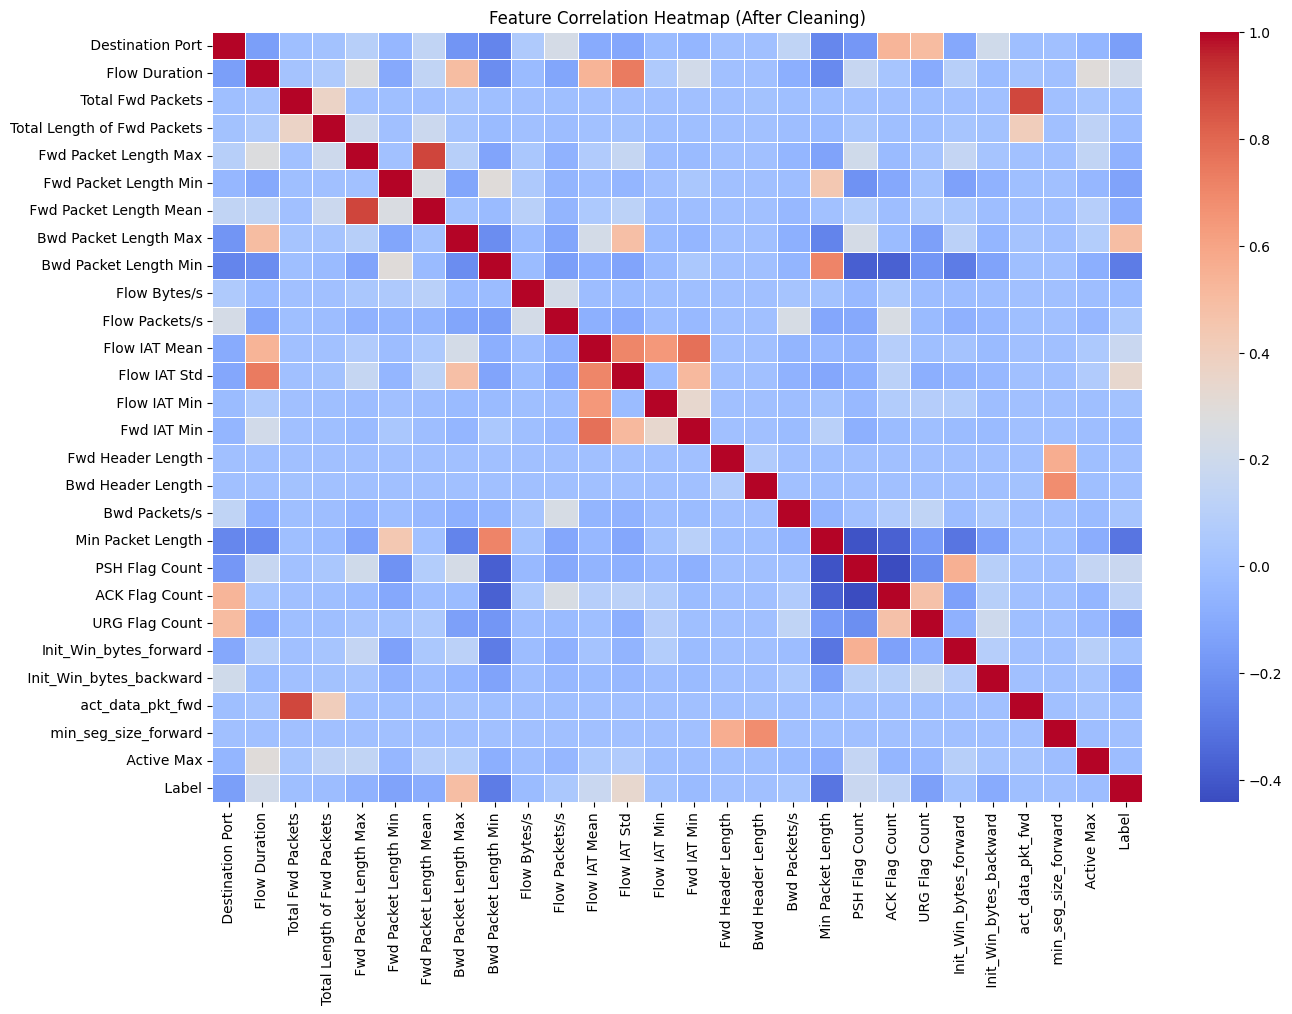

In [19]:
# Correlation Heatmap (After Cleaning)
plt.figure(figsize=(15, 10))
sns.heatmap(df_cleaned.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap (After Cleaning)")
plt.show()
